# Using MLFlow to serve the prediction

This ML Model will predict sales only on stores which are open and when there is some sales because there is no sales when store is closed.

# Importing Libraries

In [1]:
# Importing Machine Learning & Evaluation Metrics Libraries
from scipy.stats import zscore
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score as r2, mean_squared_error as mse
import math
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix,classification_report
import pandas as pd
import warnings
import numpy as np

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Loading Datasets

In [3]:
df2 = pd.read_csv("store.csv")

df1 = pd.read_csv("train.csv",parse_dates = True, index_col = 'Date')


# Checking for Null Values

In [4]:
# Analyzing Null Values for both the Datasets
print('df1 \n',df1.isnull().sum(),'\n\n')
print('df2 \n',df2.isnull().sum())

df1 
 Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64 


df2 
 Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


**Observation:- Null values are present in store.csv (df2) dataset only. There is no any missing value available in Rossmann(df1) datasets.

**Now we wll calculate the missing value in percentage of df2 (store datasets) only beacuse other dataset (df1) has no null values.

In [66]:
#Null value (percentage) of total dataset(store).
(df2.isnull().sum()/df2.shape[0])*100

Store                        0.0
StoreType                    0.0
Assortment                   0.0
CompetitionDistance          0.0
CompetitionOpenSinceMonth    0.0
CompetitionOpenSinceYear     0.0
Promo2                       0.0
Promo2SinceWeek              0.0
Promo2SinceYear              0.0
PromoInterval                0.0
dtype: float64

**Observation:- We can see the high percentage of missing/null values in some features of the 'store' dataset(df1). So, now we will try to replace these with some suitable values as they won't help in our model. Let's analyse their distribution.

# Handling Null Values

In [6]:
# Handling Missing Values
# Replacing NaN values in 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval' by 0
df2['Promo2SinceWeek'] = df2['Promo2SinceWeek'].fillna(0)
df2['Promo2SinceYear'] = df2['Promo2SinceYear'].fillna(0)
df2['PromoInterval'] = df2['PromoInterval'].fillna(0)

# Replacing NaN values in 'CompetitionDistance' with Median 
df2['CompetitionDistance'] = df2['CompetitionDistance'].fillna(df2['CompetitionDistance'].median())

# Replacing NaN values in 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear' with Mode
df2['CompetitionOpenSinceMonth'] = df2['CompetitionOpenSinceMonth'].fillna(df2['CompetitionOpenSinceMonth'].mode().iloc[0])
df2['CompetitionOpenSinceYear'] = df2['CompetitionOpenSinceYear'].fillna(df2['CompetitionOpenSinceYear'].mode().iloc[0])

In [7]:
# Checking if any Null Value left for any feature
print(df2.isnull().sum())

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64


# Working with 'Date' Column

In [8]:
# Assuming df1 is your DataFrame with a RangeIndex
# Convert the index to DatetimeIndex
df1.index = pd.to_datetime(df1.index)

# Now, you can extract year, month, day, and week of year
df1['Year'] = df1.index.year
df1['Month'] = df1.index.month
df1['Day'] = df1.index.day
df1['WeekOfYear'] = df1.index.isocalendar().week
df1 = df1.reset_index()

# Checking for Duplicates

In [9]:
# Checking for duplicates 
print(df1.duplicated().sum())
print(df2.duplicated().sum())

0
0


# Merging both the Datasets

In [10]:
# Joining/Merging Both the Dataframes 
rossmann_Store_df = pd.merge(df1, df2, how='left', on='Store')

# Understanding the Dataset

In [11]:
# Using head function, first 5 rows of Merged dataset
rossmann_Store_df.head().T

,0,1,2,3,4
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,0,0,0,0,0
SchoolHoliday,1,1,1,1,1
Year,2015,2015,2015,2015,2015


In [12]:
# Using len function, calculating the no. of records in the datset
len(rossmann_Store_df)

1017209

In [13]:
# Using columns attribute, list of features/columns name in the dataset
rossmann_Store_df.columns

Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [14]:
# Checking for duplicates in the merged dataset
rossmann_Store_df.duplicated().sum()

0

In [15]:
# Summary of merged dataset
rossmann_Store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 22 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Date                       1017209 non-null  datetime64[ns]
 1   Store                      1017209 non-null  int64         
 2   DayOfWeek                  1017209 non-null  int64         
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   Year                       1017209 non-null  int64         
 10  Month                      1017209 non-null  int64         
 11  Day                        1017209 no

# Changing Datatype of some columns

In [16]:
# Changing datatype of some columns
rossmann_Store_df['CompetitionOpenSinceMonth'] = rossmann_Store_df['CompetitionOpenSinceMonth'].astype(int)
rossmann_Store_df['CompetitionOpenSinceYear'] = rossmann_Store_df['CompetitionOpenSinceYear'].astype(int)
rossmann_Store_df['Promo2SinceWeek'] = rossmann_Store_df['Promo2SinceWeek'].astype(int)
rossmann_Store_df['Promo2SinceYear'] = rossmann_Store_df['Promo2SinceYear'].astype(int)

In [17]:
# Description of Numerical columns/features
rossmann_Store_df.describe().round(2)

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Year,Month,Day,WeekOfYear,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1017209.00,1017209.0,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.0,1017209.00,1017209.00,1017209.00,1017209.0,1017209.00,1017209.00
mean,558.43,4.0,5773.82,633.15,0.83,0.38,0.18,2013.83,5.85,15.70,23.62,5422.02,7.79,2010.06,0.5,11.65,1007.01
std,321.91,2.0,3849.93,464.41,0.38,0.49,0.38,0.78,3.33,8.79,14.43,7706.92,2.78,5.34,0.5,15.32,1005.88
min,1.00,1.0,0.00,0.00,0.00,0.00,0.00,2013.00,1.00,1.00,1.0,20.00,1.00,1900.00,0.0,0.00,0.00
25%,280.00,2.0,3727.00,405.00,1.00,0.00,0.00,2013.00,3.00,8.00,11.0,710.00,6.00,2008.00,0.0,0.00,0.00
50%,558.00,4.0,5744.00,609.00,1.00,0.00,0.00,2014.00,6.00,16.00,22.0,2325.00,9.00,2012.00,1.0,1.00,2009.00
75%,838.00,6.0,7856.00,837.00,1.00,1.00,0.00,2014.00,8.00,23.00,35.0,6880.00,9.00,2013.00,1.0,22.00,2012.00
max,1115.00,7.0,41551.00,7388.00,1.00,1.00,1.00,2015.00,12.00,31.00,52.0,75860.00,12.00,2015.00,1.0,50.00,2015.00


# Feature Engineering

In [18]:
# Making a copy of Dataframe (rossmann_df) and further working on it
final_df  = rossmann_Store_df.copy()

In [19]:
# Filtering stores which are closed as they wont generate sales
final_df = final_df[final_df.Open != 0]


In [20]:
# Dropping Open column as it is not a variable anymore
final_df = final_df.drop('Open', axis=1)

In [21]:
# Stores with zero Sales
final_df[final_df.Sales == 0]['Store'].sum()

31460

In [22]:
# Percentage of open stored with zero sales
final_df[final_df.Sales == 0]['Store'].sum()/final_df.Sales.sum().round(2) * 100

0.0005356552440563345

In [23]:
# Filtering rows with Sales > 0
final_df = final_df[final_df.Sales != 0]

In [24]:
# Checking
final_df[final_df.Sales == 0]['Store'].sum()

0

In [25]:
# list of columns in final_df dataframe
final_df.columns

Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Customers', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [26]:
# Description of Numerical columns/features
final_df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Store,844338.0,558.42,321.73,1.0,280.0,558.0,837.0,1115.0
DayOfWeek,844338.0,3.52,1.72,1.0,2.0,3.0,5.0,7.0
Sales,844338.0,6955.96,3103.82,46.0,4859.0,6369.0,8360.0,41551.0
Customers,844338.0,762.78,401.19,8.0,519.0,676.0,893.0,7388.0
Promo,844338.0,0.45,0.5,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,844338.0,0.19,0.4,0.0,0.0,0.0,0.0,1.0
Year,844338.0,2013.83,0.78,2013.0,2013.0,2014.0,2014.0,2015.0
Month,844338.0,5.85,3.32,1.0,3.0,6.0,8.0,12.0
Day,844338.0,15.84,8.68,1.0,8.0,16.0,23.0,31.0
WeekOfYear,844338.0,23.65,14.39,1.0,11.0,23.0,35.0,52.0


In [27]:
# Summary of final_df
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017190
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Date                       844338 non-null  datetime64[ns]
 1   Store                      844338 non-null  int64         
 2   DayOfWeek                  844338 non-null  int64         
 3   Sales                      844338 non-null  int64         
 4   Customers                  844338 non-null  int64         
 5   Promo                      844338 non-null  int64         
 6   StateHoliday               844338 non-null  object        
 7   SchoolHoliday              844338 non-null  int64         
 8   Year                       844338 non-null  int64         
 9   Month                      844338 non-null  int64         
 10  Day                        844338 non-null  int64         
 11  WeekOfYear                 844338 non-null  UInt32 

In [28]:
# Nominal Variales
set(final_df.StateHoliday), set(final_df.StoreType), set(final_df.Assortment), set(final_df.PromoInterval)

({0, '0', 'a', 'b', 'c'},
 {'a', 'b', 'c', 'd'},
 {'a', 'b', 'c'},
 {0, 'Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'})

In [29]:
# Converting number 0 to string 0 in StateHoliday column
final_df.loc[final_df.StateHoliday == 0,'StateHoliday'] = final_df.loc[final_df.StateHoliday == 0,'StateHoliday'] 

In [30]:
# Converting number 0 to string 0 in promointerval column
final_df.loc[final_df.PromoInterval == 0,'PromoInterval'] = final_df.loc[final_df.PromoInterval == '0','PromoInterval']

In [31]:
# Dropping -inf values
final_df.drop(final_df[final_df['Sales'] == float("-inf")].index,inplace=True)

# Encoding all categorical varibale to numeric values

In [32]:

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

final_df['StoreType'] = label_encoder.fit_transform(final_df['StoreType'])
final_df['Assortment'] = label_encoder.fit_transform(final_df['Assortment'])
#final_df['StateHoliday'] = label_encoder.fit_transform(final_df['StateHoliday'])
final_df['PromoInterval'] = label_encoder.fit_transform(final_df['PromoInterval'])

final_df.head().T

,0,1,2,3,4
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Promo,1,1,1,1,1
StateHoliday,0,0,0,0,0
SchoolHoliday,1,1,1,1,1
Year,2015,2015,2015,2015,2015
Month,7,7,7,7,7


In [33]:
final_df['StateHoliday'] = pd.to_numeric(final_df['StateHoliday'], errors='coerce')
final_df['StateHoliday'].fillna(0, inplace=True)  # Replace NaN values with 0 or any other value
final_df['StateHoliday'] = final_df['StateHoliday'].astype(int)

In [34]:
print(final_df['StateHoliday'].unique())

[0]


In [35]:
set(final_df.StateHoliday), set(final_df.StoreType), set(final_df.Assortment), set(final_df.PromoInterval)

({0}, {0, 1, 2, 3}, {0, 1, 2}, {0, 1, 2, 3})

In [36]:
# Defining Dependent Variable
dependent_variable = 'Sales'
# Defining Independent Varibale
independent_variables = list(final_df.columns.drop(['Date','Sales','Store',]))

In [37]:
# List of independent variables
independent_variables

['DayOfWeek',
 'Customers',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'Year',
 'Month',
 'Day',
 'WeekOfYear',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval']

In [38]:
# Creating the data of independent variables
X = final_df[independent_variables].values

# Creating the data of dependent variable
y = final_df[dependent_variable].values

# Splitting the Dataset into Test and Train

In [39]:
# Splitting the Dataset into Test and Train
X = pd.DataFrame(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
# Shape of train data
print(X_train.shape)
# Shape of test data
print(X_test.shape)

(675470, 18)
(168868, 18)


# Model - 1 - Linear Regression (OLS)

In [40]:
# Fitting Multiple Linear Regression to the Training set
# Formation of equation
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [41]:
# Intercept of equation
regressor.intercept_

-344710.25514077564

In [42]:
# Coefficients OR Model parameters of equation
regressor.coef_

array([-6.69181608e+01,  6.35850015e+00,  1.29082179e+03, -6.56417782e-08,
        3.38566369e+01,  1.75976938e+02,  4.87102093e+01,  1.29607213e+00,
       -2.10654060e+00,  2.72582067e+02,  2.16896982e+02,  2.82276573e-02,
       -1.35615984e+01, -4.27381309e+00,  1.24728427e+05,  1.01668170e+01,
       -6.20941398e+01, -9.35493795e+01])

In [43]:
# Predicting the Train set results
y_pred_train = regressor.predict(X_train)

In [44]:
# Predicting the Test set results
y_pred_test = regressor.predict(X_test)

In [45]:
# Defining RMSE function
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(x, y):
    return sqrt(mean_squared_error(x, y))

# Defining MAPE function
def mape(x, y): 
    return np.mean(np.abs((x - y) / x)) * 100 

In [46]:
# Evaluation Metrics for Linear Regression

print("Regresion Model Training Score" , ":" , regressor.score(X_train, y_train),
      "Model Test Score" ,":" , regressor.score(X_test, y_test))

print("Training RMSE", ":", rmse(y_train, y_pred_train),
      "Testing RMSE", ":", rmse(y_test, y_pred_test))

print("Training MAPE", ":", mape(y_train, y_pred_train),
      "Testing MAPE", ":", mape(y_test, y_pred_test))

r2 = r2_score(y_test, y_pred_test)
print("R2 :" ,r2)

Regresion Model Training Score : 0.7647327184430374 Model Test Score : 0.7607418193781323
Training RMSE : 1504.9241557295234 Testing RMSE : 1520.4588391770449
Training MAPE : 15.876188810899505 Testing MAPE : 15.919220963538569
R2 : 0.7607418193781323


Text(0, 0.5, 'Predicted values')

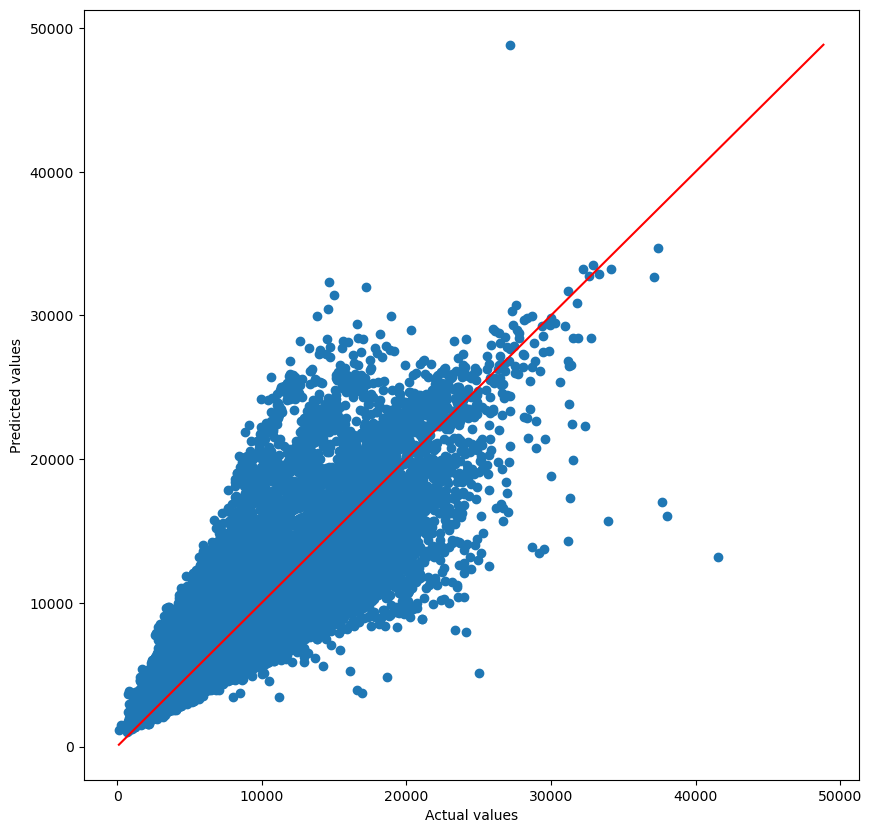

In [50]:
# Showing the optimally fitted line
plt.figure(figsize=(10,10))
plt.scatter(y_test,y_pred_test)

p1 = max(max(y_pred_test),max(y_test))
p2 = min(min(y_pred_test),min(y_test))
plt.plot([p1,p2],[p1,p2],c='r')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

# Model - 2 - Lasso Regression (L1)

In [47]:
# Fitting Lasso Regression to the Training set
lasso = Lasso(alpha = 0.2, max_iter=10000)
lasso.fit(X_train, y_train)

Lasso(alpha=0.2, max_iter=10000)

In [51]:
# Predicting the Test set results
y_pred_lasso = lasso.predict(X_test)

In [52]:
# Predicting the Train set results
y_pred_train_lasso = lasso.predict(X_train)

In [53]:
# Evaluation Metrics for Lasson Regression (L1)

print("Regresion Model Training Score" , ":" , lasso.score(X_train, y_train),
      "Model Test Score" ,":" , lasso.score(X_test, y_test))

print("Training RMSE", ":", rmse(y_train, y_pred_train_lasso),
      "Testing RMSE", ":", rmse(y_test, y_pred_lasso))

print("Training MAPE", ":", mape(y_train, y_pred_train_lasso),
      "Testing MAPE", ":", mape(y_test, y_pred_lasso))

r2 = r2_score(y_test, y_pred_lasso)
print("R2 :" ,r2)

Regresion Model Training Score : 0.7642293582112447 Model Test Score : 0.7602704845313686
Training RMSE : 1506.5332069690814 Testing RMSE : 1521.9557423014805
Training MAPE : 15.899140877422417 Testing MAPE : 15.93819226290272
R2 : 0.7602704845313686


# Model - 3 - Ridge Regression (L2)

In [54]:
# Fitting Ridge Regression to the Training set
ridge = Ridge(alpha = 0.5)
ridge.fit(X_train, y_train)

Ridge(alpha=0.5)

In [55]:
# Predicting the Test set results
y_pred_ridge = ridge.predict(X_test)

In [56]:
# Predicting the Train set results
y_pred_train_ridge = ridge.predict(X_train)

In [57]:
# Evaluation Metrics for Ridge Regression (L2)

print("Regresion Model Training Score" , ":" , ridge.score(X_train, y_train),
      "Model Test Score" ,":" , ridge.score(X_test, y_test))

print("Training RMSE", ":", rmse(y_train, y_pred_train_ridge),
      "Testing RMSE", ":", rmse(y_test, y_pred_ridge))

print("Training MAPE", ":", mape(y_train, y_pred_train_ridge),
      "Testing MAPE", ":", mape(y_test, y_pred_ridge))

r2 = r2_score(y_test, y_pred_ridge)
print("R2 :" ,r2)

Regresion Model Training Score : 0.7644833749882898 Model Test Score : 0.7605140408028379
Training RMSE : 1505.7214268477057 Testing RMSE : 1521.1824206209699
Training MAPE : 15.885898111705146 Testing MAPE : 15.926092954181204
R2 : 0.7605140408028379


# Model - 4 - Decision Tree

In [58]:
# Fitting Decision Tree to the Training set
dt = DecisionTreeRegressor(max_depth=5)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5)

In [59]:
# Predicting the Test set results
y_pred_dt = dt.predict(X_test)

In [60]:
# Predicting the Train set results
y_train_dt = dt.predict(X_train)

In [61]:
# Evaluation Metrics for Decision Tree

print("Regresion Model Training Score" , ":" , dt.score(X_train, y_train),
      "Model Test Score" ,":" , dt.score(X_test, y_test))

print("Training RMSE", ":", rmse(y_train, y_train_dt),
      "Testing RMSE", ":", rmse(y_test, y_pred_dt))

print("Training MAPE", ":", mape(y_train, y_train_dt),
      "Testing MAPE", ":", mape(y_test, y_pred_dt))

r2 = r2_score(y_test, y_pred_ridge)
print("R2 :" ,r2)

Regresion Model Training Score : 0.7888292421302908 Model Test Score : 0.7873972039019176
Training RMSE : 1425.774146033609 Testing RMSE : 1433.2625581718194
Training MAPE : 15.449198981158546 Testing MAPE : 15.477798070088266
R2 : 0.7605140408028379


# Model - 5 - Random Forest

In [62]:
# Fitting Random Forest to the Training set
random_forest=RandomForestRegressor(n_estimators =100,max_depth=5)
random_forest.fit(X_train, y_train)


RandomForestRegressor(max_depth=5)

In [63]:
# Predicting the Train set results
y_pred_train_rf = random_forest.predict(X_train)

In [64]:
# Predicting the Test set results
y_pred_rf=random_forest.predict(X_test)

In [65]:
# Evaluation Metrics for Random Forest

print("Regresion Model Training Score" , ":" , random_forest.score(X_train, y_train),
      "Model Test Score" ,":" , random_forest.score(X_test, y_test))

print("Training RMSE", ":", rmse(y_train, y_pred_train_rf),
      "Testing RMSE", ":", rmse(y_test, y_pred_rf))

print("Training MAPE", ":", mape(y_train, y_pred_train_rf),
      "Testing MAPE", ":", mape(y_test, y_pred_rf))

r2 = r2_score(y_test, y_pred_rf)
print("R2 :" ,r2)

Regresion Model Training Score : 0.7982705738662563 Model Test Score : 0.7969966254410782
Training RMSE : 1393.536898287651 Testing RMSE : 1400.5315555496184
Training MAPE : 15.194385736079402 Testing MAPE : 15.221098222760787
R2 : 0.7969966254410782


# Conclusion from Model

By Looking at the evaluation metrices obtained on implementing different sort of regression model, we decided to go with the Random Forest model.The maximum R^2 was seen in Random Forest model with the value 0.79699. It means our best accurate model is able to explain approx/almost 79% of variances in the datasets.

# THANK YOU.



# Hope model will help the Store managers to predict the daily sales accuartely in advance. 